# Performance Results

The goal here is to compare the performance results with different contexts:
- Baseline (No Context)
- RAG all Wikipedia (FAISS)
- RAG selected samples
- Datamodels


## Summary

- [Load Data]()
- [Create FAISS]()
- [Create different contexts]()
- [Run Inferences]()
- [Compare Results]()

In [1]:
import polars as pl
import torch
import os
import random
import numpy as np


os.environ["CUDA_VISIBLE_DEVICES"] = "0"
seed = 42

torch.backends.cudnn.enabled = False
# NumPy
np.random.seed(seed)
random.seed(seed)
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of GPUs available: 1
GPU 0: NVIDIA RTX A5000


## Load Data

In [2]:
## Questions

questions = []
for i in range(5):
    questions.append(pl.read_csv(f"question_{i}_datamodels/test_set.csv"))

questions = pl.concat(questions)
questions.select("question").to_numpy().flatten()

array(['when did the who perform at the super bowl',
       'why was there so much interest in cuba both before and after the civil war',
       'who developed the first periodic table with 8 columns',
       'the organization of the formal elements in an art work',
       'where did the french king live before versailles'], dtype=object)

In [3]:
### Train samples
train_sets = []
for i in range(5):
    train_sets.append(pl.read_csv(f"question_{i}_datamodels/train_set.csv").with_columns(pl.lit(f"question_{i}").alias("question_id")))
train = pl.concat(train_sets)

### Load weights
weights_set = []
for i in range(5):
    weights = torch.load(f"question_{i}_datamodels/models/regression_question_{i}/weights.pt").to("cpu")
    weights_set.append(weights)

## add weights to sample training
list_weights = []
for set in weights_set:
    for _w in set[0]:
        list_weights.append(float(_w.item()))


train = train.with_columns(
    pl.Series("weights", list_weights),
    pl.when(pl.col("idx_right").is_not_null())
        .then(True)
        .otherwise(False)
        .alias("is_from_same_page")

)
train.head()

/tmp/ipykernel_1495768/2729841633.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"question_{i}_datamodels/models/regression_question_{i}/weights.

idx,text,title,idx_right,question_id,weights,is_from_same_page
i64,str,str,i64,str,f64,bool
0,"""Date : Feb 5 , 2017 Location :…","""List of Super Bowl halftime sh…",20970820,"""question_0""",0.038918,true
1,"""Date : Feb 4 , 2018 Location :…","""List of Super Bowl halftime sh…",20970820,"""question_0""",-0.15716,true
2,"""Date : Feb 3 , 2013 Location :…","""List of Super Bowl halftime sh…",20970820,"""question_0""",-0.050358,true
3,"""The NFL does not pay the halft…","""List of Super Bowl halftime sh…",20970820,"""question_0""",-0.164697,true
4,"""LI Main article : Super Bowl L…","""List of Super Bowl halftime sh…",20970820,"""question_0""",-0.113502,true


In [4]:
## Load Wiki
WIKI_PATH = "../../data/wiki_dump2018_nq_open/processed/wiki.feather"
wiki = pl.read_ipc(WIKI_PATH).with_row_index("idx")
wiki.head()

idx,text,title
u32,str,str
0,"""Aaron Aaron ( or ; ""Ahärôn"") i…","""Aaron"""
1,"""God at Sinai granted Aaron the…","""Aaron"""
2,"""his rod turn into a snake. The…","""Aaron"""
3,"""however, Aaron and Hur remaine…","""Aaron"""
4,"""Aaron and his sons to the prie…","""Aaron"""


In [5]:
target = []
random = []
for i in range(5):
    target_i = pl.read_ipc(f"question_{i}_datamodels/target.feather").with_columns(pl.lit(f"question_{i}").alias("question_id"))
    random_i = pl.read_ipc(f"question_{i}_datamodels/random.feather").with_columns(pl.lit(f"question_{i}").alias("question_id"))
    target.append(target_i)
    random.append(random_i)

target = pl.concat(target)
random = pl.concat(random)

## Create FAISS

In [6]:
from FlagEmbedding import FlagModel
import faiss
from tqdm import tqdm  

EMBERDDER_PATH = "../../models/llms/bge-base-en-v1.5"
VDB_PATH = "../../data/wiki_dump2018_nq_open/wiki2.index"
embedder = FlagModel(EMBERDDER_PATH, devices=["cuda:0"], use_fp16=True)



/home/caio.rhoden/miniconda3/envs/nq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# index = faiss.IndexScalarQuantizer(768, 8)
index = faiss.read_index(VDB_PATH)
index.ntotal

21035236

In [8]:

# total_size = len(wiki)
# batch_size = 80000
# torch.backends.cuda.enable_cudnn_sdp(False)

# for start in range(80000, total_size, batch_size):
    
#     end = min(start + batch_size, total_size)
#     print(f"End: {end}")
    
#     batch_texts = wiki[start:end].select("text").to_numpy().flatten().tolist()
    
#     # Encode the current batch
#     batch_embeddings = embedder.encode(
#         batch_texts,
#         convert_to_numpy=True,
#     )
    
#     # Add to index
#     index.add(batch_embeddings.astype('float32'))
#     faiss.write_index(index, "wiki.index")

    
#     # Optional: Clear memory if needed
#     del batch_texts, batch_embeddings


In [9]:
### Demo FAISS search
test_query = questions[1]["question"].to_numpy().flatten()[0]
query_embedding = embedder.encode(
    [test_query],
    convert_to_numpy=True,
)
query_embedding = query_embedding.astype('float32').reshape(1, -1)
distances, indices = index.search(query_embedding, 4)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [10]:
indices, distances

(array([[15381066, 16570529,  9835518,  3034972]]),
 array([[336.45056, 337.81207, 337.83398, 337.87286]], dtype=float32))

In [11]:
datamodels_training_l2 = faiss.IndexScalarQuantizer(768, 8)
batch_texts = train.select("text").to_numpy().flatten().tolist()
    
# Encode the current batch
batch_embeddings = embedder.encode(
    batch_texts,
    convert_to_numpy=True,
)

# Add to index
datamodels_training_l2.add(batch_embeddings.astype('float32'))
faiss.write_index(datamodels_training_l2, "datamodels_training_l2.index")
# Optional: Clear memory if needed
del batch_texts, batch_embeddings

Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. E

In [12]:
datamodels_training_ip = faiss.IndexScalarQuantizer(768, 8, faiss.METRIC_INNER_PRODUCT)
batch_texts = train.select("text").to_numpy().flatten().tolist()
    
# Encode the current batch
batch_embeddings = embedder.encode(
    batch_texts,
    convert_to_numpy=True,
)

# Add to index
datamodels_training_ip.add(batch_embeddings.astype('float32'))
faiss.write_index(datamodels_training_ip, "datamodels_training_ip.index")
# Optional: Clear memory if needed
del batch_texts, batch_embeddings

Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. Error: libnvrtc.so.12: cannot open shared object file: No such file or directory
Could not load library libnvrtc.so.12. E

## Create Contexts

In [13]:
### FAISS context
faiss_context = {}

for i in tqdm(range(len(questions))):

    question = questions[i]["question"].to_numpy().flatten()[0]
    print(question)
    query_embedding = embedder.encode(
        [question],
        convert_to_numpy=True,
    )
    query_embedding = query_embedding.astype('float32').reshape(1, -1)
    distances, indices = index.search(query_embedding, 4)

    faiss_context[f"question_{i}"] = [(wiki[int(j)]["title"].to_numpy().flatten()[0], wiki[int(j)]["text"].to_numpy().flatten()[0])  for j in indices[0]]
    print(f"Scores: {distances}")
    print(f"Indices: {indices}")

  0%|          | 0/5 [00:00<?, ?it/s]

when did the who perform at the super bowl


 20%|██        | 1/5 [00:01<00:06,  1.73s/it]

Scores: [[336.93982 337.3286  337.64267 337.67987]]
Indices: [[13354354  5365529  5025504  9835518]]
why was there so much interest in cuba both before and after the civil war


 40%|████      | 2/5 [00:03<00:04,  1.65s/it]

Scores: [[336.45056 337.81207 337.83398 337.87286]]
Indices: [[15381066 16570529  9835518  3034972]]
who developed the first periodic table with 8 columns


 60%|██████    | 3/5 [00:04<00:03,  1.64s/it]

Scores: [[335.7442  336.41965 337.17447 337.4588 ]]
Indices: [[ 9835518  3034972 12720822 20127704]]
the organization of the formal elements in an art work


 80%|████████  | 4/5 [00:06<00:01,  1.63s/it]

Scores: [[336.43555 336.66815 337.47266 337.72684]]
Indices: [[ 9835518  3034972 15381066 12515279]]
where did the french king live before versailles


100%|██████████| 5/5 [00:08<00:00,  1.63s/it]

Scores: [[336.3706  336.41226 337.219   337.78336]]
Indices: [[ 9208755  3034972  9835518 15381066]]


In [14]:
faiss_context_ip = {}
wiki_ip_path =  "../../data/wiki_dump2018_nq_open/wiki_ip.index"
index_ip = faiss.read_index(wiki_ip_path)

for i in tqdm(range(len(questions))):

    question = questions[i]["question"].to_numpy().flatten()[0]
    print(question)
    query_embedding = embedder.encode(
        [question],
        convert_to_numpy=True,
    )
    query_embedding = query_embedding.astype('float32').reshape(1, -1)
    distances, indices = index_ip.search(query_embedding, 4)

    faiss_context_ip[f"question_{i}"] = [(wiki[int(j)]["title"].to_numpy().flatten()[0], wiki[int(j)]["text"].to_numpy().flatten()[0])  for j in indices[0]]
    print(f"Scores: {distances}")
    print(f"Indices: {indices}")

  0%|          | 0/5 [00:00<?, ?it/s]

when did the who perform at the super bowl


 20%|██        | 1/5 [00:01<00:05,  1.46s/it]

Scores: [[8.983183 8.968657 8.956624 8.830452]]
Indices: [[14142581 15448024  1357754  2189032]]
why was there so much interest in cuba both before and after the civil war


 40%|████      | 2/5 [00:02<00:04,  1.46s/it]

Scores: [[8.684044 8.457449 8.129929 8.062746]]
Indices: [[14707718 11085636 13370561 12459444]]
who developed the first periodic table with 8 columns


 60%|██████    | 3/5 [00:04<00:02,  1.46s/it]

Scores: [[9.056978 9.024617 8.822065 8.817654]]
Indices: [[ 6586968    69045  3037811 19082953]]
the organization of the formal elements in an art work


 80%|████████  | 4/5 [00:05<00:01,  1.46s/it]

Scores: [[8.633635 8.305628 8.292051 8.291437]]
Indices: [[21009643  3372702  5022622 14115032]]
where did the french king live before versailles


100%|██████████| 5/5 [00:07<00:00,  1.46s/it]

Scores: [[8.527322 8.412604 8.365586 8.327864]]
Indices: [[ 8682560  4655528  2312098 15274784]]


In [15]:
### FAISS context - Datamodels Training L2
faiss_context_datamodels_l2 = {}

for i in tqdm(range(len(questions))):

    question = questions[i]["question"].to_numpy().flatten()[0]
    print(question)
    query_embedding = embedder.encode(
        [question],
        convert_to_numpy=True,
    )
    query_embedding = query_embedding.astype('float32').reshape(1, -1)
    distances, indices = datamodels_training_l2.search(query_embedding, 4)

    faiss_context_datamodels_l2[f"question_{i}"] = [(train[int(j)]["title"].to_numpy().flatten()[0], train[int(j)]["text"].to_numpy().flatten()[0])  for j in indices[0]]
    print(f"Scores: {distances}")
    print(f"Indices: {indices}")

100%|██████████| 5/5 [00:00<00:00, 65.76it/s]

when did the who perform at the super bowl
Scores: [[358.2376  358.49066 359.51453 360.57214]]
Indices: [[105 159 162  97]]
why was there so much interest in cuba both before and after the civil war
Scores: [[357.87848 359.77478 359.95105 360.1405 ]]
Indices: [[105 162  97 159]]
who developed the first periodic table with 8 columns
Scores: [[354.10104 357.06946 359.53302 359.5529 ]]
Indices: [[ 43 162 106  97]]
the organization of the formal elements in an art work
Scores: [[354.5064  358.04926 359.45966 359.62616]]
Indices: [[ 97 106  43 162]]
where did the french king live before versailles
Scores: [[356.85376 358.41727 358.92175 359.9263 ]]
Indices: [[129 127 162  97]]


In [16]:
### FAISS context - Datamodels Training L2
faiss_context_datamodels_ip = {}

for i in tqdm(range(len(questions))):

    question = questions[i]["question"].to_numpy().flatten()[0]
    print(question)
    query_embedding = embedder.encode(
        [question],
        convert_to_numpy=True,
    )
    query_embedding = query_embedding.astype('float32').reshape(1, -1)
    distances, indices = datamodels_training_ip.search(query_embedding, 4)

    faiss_context_datamodels_ip[f"question_{i}"] = [(train[int(j)]["title"].to_numpy().flatten()[0], train[int(j)]["text"].to_numpy().flatten()[0])  for j in indices[0]]
    print(f"Scores: {distances}")
    print(f"Indices: {indices}")

100%|██████████| 5/5 [00:00<00:00, 68.45it/s]

when did the who perform at the super bowl
Scores: [[7.065383  7.043705  6.9598308 6.6897545]]
Indices: [[5 1 4 3]]
why was there so much interest in cuba both before and after the civil war
Scores: [[7.224859 6.846028 6.570202 6.558244]]
Indices: [[23 18 16 22]]
who developed the first periodic table with 8 columns
Scores: [[8.822065 8.449621 8.42453  8.365835]]
Indices: [[32 43 52 40]]
the organization of the formal elements in an art work
Scores: [[8.281843 8.004539 7.986976 7.767872]]
Indices: [[80 81 91 95]]
where did the french king live before versailles
Scores: [[8.238254  7.5941625 7.509083  7.309235 ]]
Indices: [[130 131 154 140]]


In [17]:
datamodels_general_context = {}
for i in tqdm(range(len(questions))):
    df_i = (
        train
        .filter(pl.col("question_id") == f"question_{i}")
        .select("text", "title", "weights")
        .sort("weights", descending=True)
        .head(4)
    )

    datamodels_general_context[f"question_{i}"] = []
    for j in range(4):
        datamodels_general_context[f"question_{i}"].append((df_i[j]["title"].to_numpy().flatten()[0], df_i[j]["text"].to_numpy().flatten()[0]))


    
    

100%|██████████| 5/5 [00:00<00:00, 798.61it/s]


In [18]:
datamodels_same_page_context = {}
for i in tqdm(range(len(questions))):
    df_i = (
        train
        .filter(pl.col("question_id") == f"question_{i}")
        .filter(pl.col("idx_right") > 0)
        .select("text", "title", "weights")
        .sort("weights", descending=True)
        .head(4)
    )

    datamodels_same_page_context[f"question_{i}"] = []
    for j in range(4):
        datamodels_same_page_context[f"question_{i}"].append((df_i[j]["title"].to_numpy().flatten()[0], df_i[j]["text"].to_numpy().flatten()[0]))


100%|██████████| 5/5 [00:00<00:00, 692.63it/s]


## Run Evaluation

In [19]:
from dmcr.models import GenericInstructModelHF
from dmcr.evaluators import Rouge_L_evaluator
model = GenericInstructModelHF("../../models/llms/Llama-3.2-3B-Instruct", quantization=True)
evaluator = Rouge_L_evaluator()

model_configs = {
            "temperature": 0.7,
            "top_p": 0.9,
            "max_length": 2048,
            "max_new_tokens": 10,
            "num_return_sequences": 5
}




Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]


In [20]:
results_df = {
    "question": [],
    "mode": [],
    "score": [],
    "generation_idx": [],
    "prediction": [],
    "target": []
}

In [21]:
## Baseline run
mode = "baseline"

for q_idx in range(5):
    outputs = model.run(
        questions[q_idx]["question"], 
        instruction="You are given a general knowledge and you MUST respond a SHORT ANSWER in 5 tokens", 
        config_params=model_configs
    )

    scores = evaluator.evaluate(
        np.array([out["generated_text"] for out in outputs]).astype(str),
        np.array([questions[q_idx]["answers"].to_numpy().flatten()[0] for _ in range(5)]).astype(str),
        None
    )

    for s_idx in range(len(scores)):

        results_df["question"].append(q_idx)
        results_df["mode"].append(mode)
        results_df["score"].append(scores[s_idx])
        results_df["generation_idx"].append(s_idx)
        results_df["prediction"].append(outputs[s_idx]["generated_text"])
        results_df["target"].append(questions[q_idx]["answers"].to_numpy().flatten()[0])



Device set to use cuda:0
Both `max_new_tokens` (=10) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
/home/caio.rhoden/miniconda3/envs/nq/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
Device set to use cuda:0
Both `max_new_tokens` (=10) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Device set to use cuda:0
Both `max_new_tokens` (=10) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please

In [22]:
## Run contexts built before
contexts = [
    ("wiki_RAG_L2", faiss_context),
    ("wiki_RAG_IP",faiss_context_ip),
    ("selected_samples_RAG_L2",faiss_context_datamodels_l2),
    ("selected_samples_RAG_IP",faiss_context_datamodels_ip),
    ("datmaodels_all",datamodels_general_context),
    ("datamodels_same_page",datamodels_same_page_context)
]

for mode in contexts:

    for q_idx in range(5):
        
        docs = mode[1][f"question_{q_idx}"]
        prompt = "Documents: \n"
        for doc_idx in range(len(docs)-1, -1, -1):
            prompt += f"Document[{3-doc_idx}](Title: {docs[doc_idx][0]}){docs[doc_idx][1]}\n\n"
        prompt += f"You are given a general knowledge based question and you MUST respond a SHORT ANSWER in 5 tokens, use the provided documents to try to answer the question \n\n Question: {questions[q_idx]['question'].to_numpy().flatten()[0]}\nAnswer: "

        outputs = model.run(
            prompt, 
            instruction="You are given a general knowledge based question and you MUST respond a SHORT ANSWER in 5 tokens, use the provided documents to try to answer the question", 
            config_params=model_configs
        )

        scores = evaluator.evaluate(
            np.array([out["generated_text"] for out in outputs]).astype(str),
            np.array([questions[q_idx]["answers"].to_numpy().flatten()[0] for _ in range(5)]).astype(str),
            None
        )

        for s_idx in range(len(scores)):

            results_df["question"].append(q_idx)
            results_df["mode"].append(mode[0])
            results_df["score"].append(scores[s_idx])
            results_df["generation_idx"].append(s_idx)
            results_df["prediction"].append(outputs[s_idx]["generated_text"])
            results_df["target"].append(questions[q_idx]["answers"].to_numpy().flatten()[0])


Device set to use cuda:0
Both `max_new_tokens` (=10) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Device set to use cuda:0
Both `max_new_tokens` (=10) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Device set to use cuda:0
Both `max_new_tokens` (=10) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Device set to use cuda:0
Both `max_new_tokens` (=10) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation fo

## Plot Results

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

results = pl.DataFrame(results_df)


/tmp/ipykernel_1495768/3729674206.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1495768/3729674206.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1495768/3729674206.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1495768/3729674206.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykern

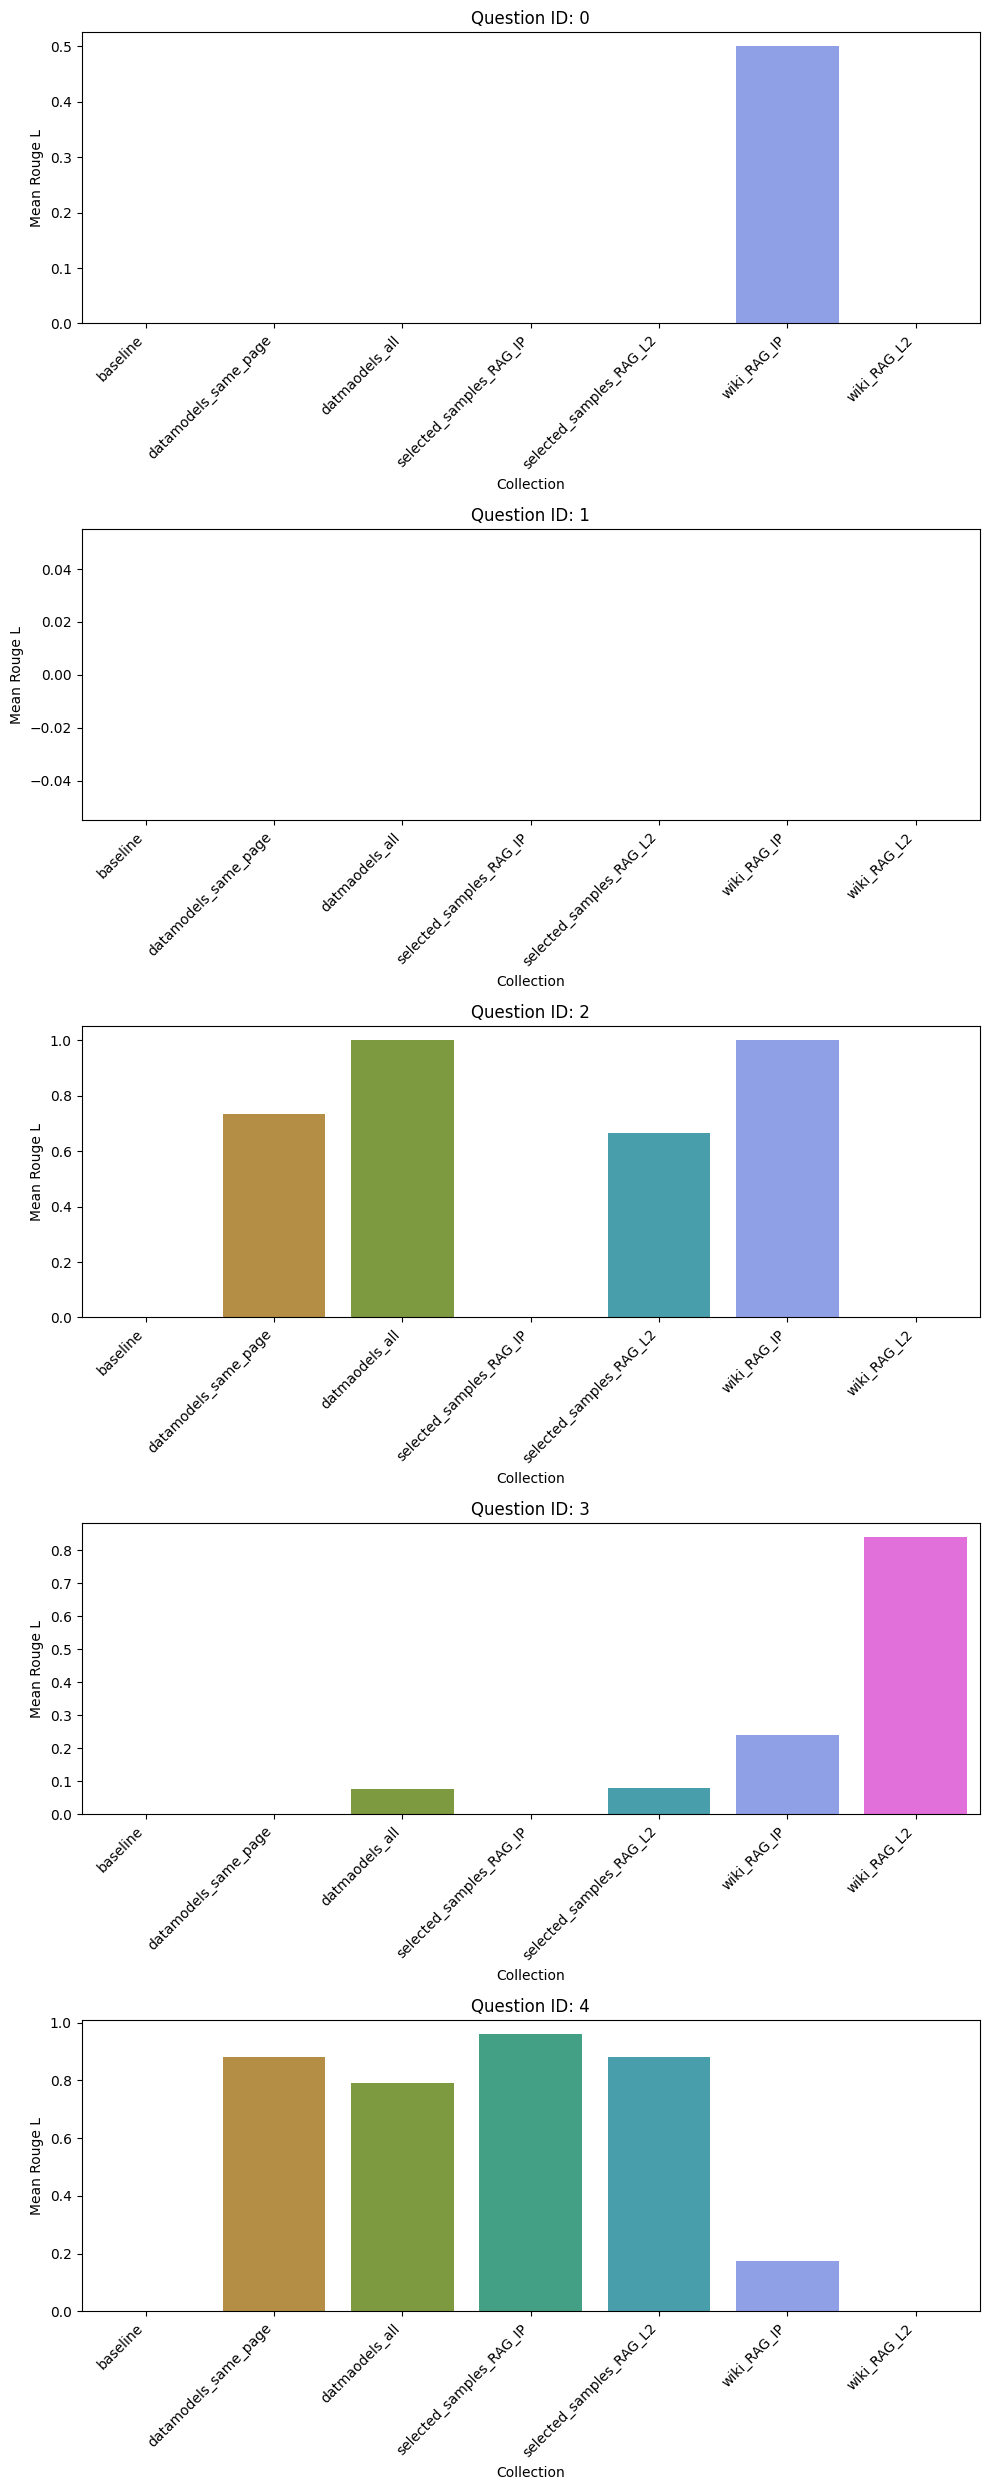

In [31]:
fig, axes = plt.subplots(5, figsize=(10, 25))

_aggregate_results = (
    results
    .group_by(["question", "mode"])
    .agg(
        pl.col("score").mean().alias("mean_rouge_l")
    )
    .sort("mode")
)

# Create a bar plot for each question_id
for i in range(5):

    df = _aggregate_results.filter(pl.col("question") == i)
    sns.barplot(
        data=df,
        x = "mode",
        y="mean_rouge_l",
        hue="mode",
        palette="husl",
        ax=axes[i]
    )
   
    
    # Customize the plot
    axes[i].set_title(f'Question ID: {i}')
    axes[i].set_xlabel("Collection")
    axes[i].set_ylabel("Mean Rouge L")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
plt.tight_layout()
plt.show()

In [25]:
results.select(["prediction", "target"]).to_numpy()

array([['Who performed at the Who concert?', 'Feb 7 , 2010'],
       ['The Who performed at Woodstock in 1969', 'Feb 7 , 2010'],
       ['The Who released their debut album "My Generation"',
        'Feb 7 , 2010'],
       ['The Who released "My Generation" in 196', 'Feb 7 , 2010'],
       ['The Who performed at the 2001 Rock and', 'Feb 7 , 2010'],
       ['The question is about interest.', 'sugar markets'],
       ['The question is about historical events.', 'sugar markets'],
       ['The question is about the interest in a specific event',
        'sugar markets'],
       ["It's related to a historical event.", 'sugar markets'],
       ['The question refers to a historical event.', 'sugar markets'],
       ['Lippes', 'Dmitri Mendeleev'],
       ['Leakey', 'Dmitri Mendeleev'],
       ['Mercy Brown', 'Dmitri Mendeleev'],
       ['Merck', 'Dmitri Mendeleev'],
       ['Leakey', 'Dmitri Mendeleev'],
       ['What is the formal organization of the United Nations?',
        'composition'],


In [26]:
prompt

'Documents: \nDocument[0](Title: Tuileries Palace)French president at that time, Jacques Chirac, called for a debate on the subject. Former president Charles de Gaulle had also supported reconstruction, saying that it would "make a jewel of the centre of Paris." Sources Tuileries Palace The Tuileries Palace (, ) was a royal and imperial palace in Paris which stood on the right bank of the River Seine. It was the usual Parisian residence of most French monarchs, from Henry IV to Napoleon III, until it was burned by the Paris Commune in 1871. Built in 1564, it was gradually extended until it closed off the western\n\nDocument[1](Title: Tuileries Palace)central pavilion can be seen in Paris\' , some courtyard is in the garden of the Trocadero. Other pieces are in the Louvre, the Museum of Decorative Arts, and at schools of architecture, fine arts, and bridges and roads. The Tuileries Garden () covers ; is surrounded by the Louvre (to the east), the Seine (to the south), the Place de la Co

In [27]:
prompt

'Documents: \nDocument[0](Title: Tuileries Palace)French president at that time, Jacques Chirac, called for a debate on the subject. Former president Charles de Gaulle had also supported reconstruction, saying that it would "make a jewel of the centre of Paris." Sources Tuileries Palace The Tuileries Palace (, ) was a royal and imperial palace in Paris which stood on the right bank of the River Seine. It was the usual Parisian residence of most French monarchs, from Henry IV to Napoleon III, until it was burned by the Paris Commune in 1871. Built in 1564, it was gradually extended until it closed off the western\n\nDocument[1](Title: Tuileries Palace)central pavilion can be seen in Paris\' , some courtyard is in the garden of the Trocadero. Other pieces are in the Louvre, the Museum of Decorative Arts, and at schools of architecture, fine arts, and bridges and roads. The Tuileries Garden () covers ; is surrounded by the Louvre (to the east), the Seine (to the south), the Place de la Co